In [1]:
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rc

# Configure Matplotlib to use LaTeX
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
plt.rcParams.update({'font.size': 18})
# Use latex font 

In [3]:
def geom_boundary(trSigma, alpha, iters):
    widths = []
    for i in range(1, iters): 
        alphat = alpha / (i + i**2)
        width = 4*np.sqrt( trSigma*(8*np.log(1/alphat)+1)/i)
        widths.append(width)
    return widths

def mom_boundary(trSigma, lambda_max, alpha, iters): 

    widths = []
    for i in range(1, iters): 

        # alphat = alpha / (2*i*i)
        alphat = alpha / (i + i**2)
        # width = 4*np.sqrt(2 trSigma*(8*np.log(1/alphat)+1)/i)
        t1 = 960*np.sqrt(trSigma/(i/2))
        t2 = 240*np.sqrt(lambda_max * np.log(2/alphat) / i)
        width = max(t1, t2)
        widths.append(width)
    return widths 

def mom_boundary_dh(trSigma, lambda_max, alpha, iters): 

    widths = []
    for i in range(1, iters): 

        # check if i = 2^k for some k 
        if (i & (i-1)) == 0: 
            log_alphat = np.log(1/alpha) + 2*np.log(np.log2(i)) + 1/2
            t1 = 960*np.sqrt(trSigma/(i/2))
            t2 = 240*np.sqrt(lambda_max * (np.log(2) + log_alphat) / (i/2))
            width = max(t1, t2)
            widths.append(width)
        else: 
            widths.append(widths[-1])
                    
    return widths

def geom_boundary_dh(trSigma, alpha, iters):
    widths = []
    for i in range(1, iters): 
        if (i & (i-1)) == 0: 
            log_alphat = np.log(1/alpha) + 2*np.log(np.log2(i)) + 1/2
            width = 4*np.sqrt( trSigma*(8*log_alphat+1)/(i/2))
            widths.append(width)
        else: 
            widths.append(widths[-1])
    return widths

def cat_boundary(trSigma, alpha, iters, d, beta=1): 

    top =  beta/2 + np.log(1/alpha)
    bottom = 0 
    widths = []
    for i in range(1,iters): 
        #lambda_i = np.sqrt(np.log(1/alpha)/(d*i*np.log(i+1000)*15)) 
        lambda_i = np.sqrt(np.log(1/alpha)/(d*i*np.log(i+2000)*50)) 
        top += lambda_i**2 * np.sqrt(trSigma) * (2*np.exp(4) +1)
        bottom += lambda_i
        widths.append(top / bottom)

    return widths



In [4]:
# Normal RVs 

lambda_max = 1
alpha = 0.05 
iters = 100000 

geom_width_d5 = geom_boundary(5, alpha, iters)
geom_dh_width_d5 = geom_boundary_dh(5, alpha, iters)
mom_widths_d5 = mom_boundary(5, lambda_max, alpha, iters)
mom_dh_width_d5 = mom_boundary_dh(5, lambda_max, alpha, iters)
cat_widths_d5 = cat_boundary(5, alpha, iters, 5)

geom_width_d20 = geom_boundary(20, alpha, iters)
geom_dh_width_d20 = geom_boundary_dh(20, alpha, iters)
cat_widths_d20 = cat_boundary(20, alpha, iters, 20)

geom_width_d100 = geom_boundary(100, alpha, iters)
geom_dh_width_d100 = geom_boundary_dh(100, alpha, iters)
cat_widths_d100 = cat_boundary(100, alpha, iters, 100)


/var/folders/sz/2wd5h2r14jd0tbp7zpbm11_h0000gn/T/ipykernel_43476/2595377105.py:44: RuntimeWarning: divide by zero encountered in log
  log_alphat = np.log(1/alpha) + 2*np.log(np.log2(i)) + 1/2
/var/folders/sz/2wd5h2r14jd0tbp7zpbm11_h0000gn/T/ipykernel_43476/2595377105.py:45: RuntimeWarning: invalid value encountered in sqrt
  width = 4*np.sqrt( trSigma*(8*log_alphat+1)/(i/2))
/var/folders/sz/2wd5h2r14jd0tbp7zpbm11_h0000gn/T/ipykernel_43476/2595377105.py:30: RuntimeWarning: divide by zero encountered in log
  log_alphat = np.log(1/alpha) + 2*np.log(np.log2(i)) + 1/2
/var/folders/sz/2wd5h2r14jd0tbp7zpbm11_h0000gn/T/ipykernel_43476/2595377105.py:32: RuntimeWarning: invalid value encountered in sqrt
  t2 = 240*np.sqrt(lambda_max * (np.log(2) + log_alphat) / (i/2))


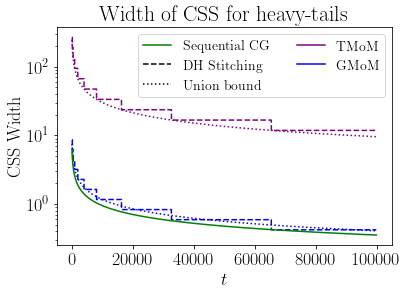

In [13]:
# Everything plot 

start = 150 

plt.plot(geom_width_d5[start:], ls=":", c='blue')
plt.plot(geom_dh_width_d5[start:], ls='--', c='blue')
plt.plot(mom_widths_d5[start:], ls=":", c='purple')
plt.plot(mom_dh_width_d5[start:], ls='--', c='purple')
plt.plot(cat_widths_d5[start:], c='green', label='Sequential CG') 


plt.plot([], [], ls='--', c='black', label='DH Stitching')
plt.plot([], [], ls=':', c='black', label='Union bound')
plt.plot([], [],  c='purple', label='TMoM')
plt.plot([], [],  c='blue', label='GMoM')
#plt.legend(loc='lower left', ncol=2, fontsize=14)
plt.legend(fontsize=14, ncol=2)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$')
plt.ylabel('CSS Width')
plt.title('Width of CSS for heavy-tails')

plt.savefig('figures/heavy_tails_gmom.png', dpi=300, bbox_inches='tight')


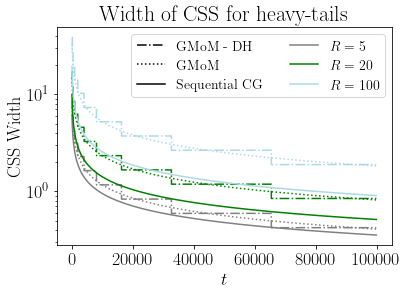

In [12]:
start = 150 

plt.plot(geom_width_d5[start:], ls=':', c='gray')
plt.plot(geom_dh_width_d5[start:], ls='-.', c='gray')
plt.plot(cat_widths_d5[start:], c='gray') # label='$d=5$')

plt.plot(geom_width_d20[start:], ls=':', c='green')
plt.plot(geom_dh_width_d20[start:], ls='-.', c='green')
plt.plot(cat_widths_d20[start:], c='green') # label='$d=20$')

plt.plot(geom_width_d100[start:], ls=':', c='lightblue')
plt.plot(geom_dh_width_d100[start:], ls='-.', c='lightblue')
plt.plot(cat_widths_d100[start:], c='lightblue') # label='$d=100$')


plt.plot([], [], ls='-.', c='black', label='GMoM - DH')
plt.plot([], [], ls=':', c='black', label='GMoM')
plt.plot([], [], c='black', label='Sequential CG')
plt.plot([], [], c='gray', label='$R=5$')
plt.plot([], [], c='green', label='$R=20$')
plt.plot([], [], c='lightblue', label='$R=100$')
#plt.legend(loc='lower left', fontsize=14, ncol=2)
plt.legend(fontsize=14, ncol=2)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$t$')
plt.ylabel('CSS Width')
plt.title('Width of CSS for heavy-tails')

plt.savefig('figures/heavy_tails.png', dpi=300, bbox_inches='tight')


In [22]:
for i in range(1000): 

    if i == 0 or (i & (i-1)) == 0: 
        print(i)

0
1
2
4
8
16
32
64
128
256
512
